# Predicting Favorable and Unfavorable Movie Reviews
The goal of this project is to utilize several machine learning models to determine what model can best predict whether a review will be positive or negative for a movie. The dataset was found on Kaggle and was scrubbed from the IMDB website.
https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews/data

This project will perform non negative matrix factorization and several clustering techniques to determine which is the most effective at predicting if a review at Starbucks will be positive or negative

#### Results
Overall non-negative matrix factorization lead to the best result. I believe this is due to the inherent nature of NMF causing some noise reduction in the data. In the future additional models could be made to try and increase the accuracy of predicting whether a movie is popular or not.

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from wordcloud import WordCloud
from sklearn.model_selection import cross_val_score
import re
import itertools
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.cluster import SpectralClustering

In [35]:
df = pd.read_csv('IMDB_Dataset.csv')

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [37]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [38]:
#Going to do some data cleaning

df.loc[:,'review']=df['review'].str.lower()
df.loc[:,'review'] = df['review'].apply(lambda x: x.replace('<br /><br />', '').replace('*', '').replace('"', '').replace(',',''))


In [39]:
for col in df.columns:
    df[col] = df[col].astype(str)

In [40]:
df

,review,sentiment
0,one of the other reviewers has mentioned that ...,positive
1,a wonderful little production. the filming tec...,positive
2,i thought this was a wonderful way to spend ti...,positive
3,basically there's a family where a little boy ...,negative
4,petter mattei's love in the time of money is a...,positive
...,...,...
49995,i thought this movie did a down right good job...,positive
49996,bad plot bad dialogue bad acting idiotic direc...,negative
49997,i am a catholic taught in parochial elementary...,negative
49998,i'm going to have to disagree with the previou...,negative


In [41]:
#Went ahead and removed punctuation marks

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


Text(0.5, 1.0, 'Counts of Positive vs Negative Reviews')

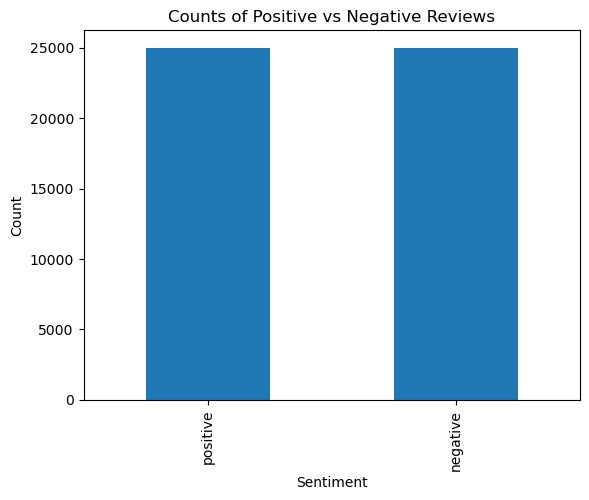

In [10]:
ratingCounts = df['sentiment'].value_counts()
ratingCounts.plot(kind='bar')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Counts of Positive vs Negative Reviews')

Lots of one star reviews, model might be able to pick up one star reviews better than other ratings because of this

In [11]:
dflength = df
dflength.loc[:,'ReviewLength'] = dflength['review'].apply(lambda x: len(x))

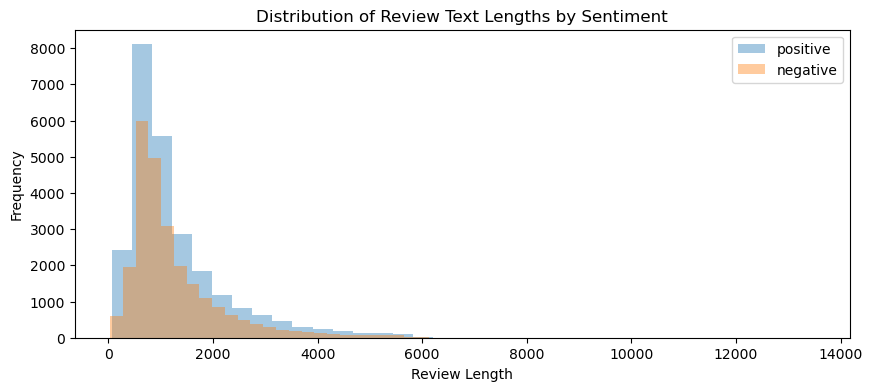

In [12]:

ratings = df['sentiment'].unique()


plt.figure(figsize=(10,4))
for rating in ratings:
    ratingdata = dflength[dflength['sentiment'] == rating]['ReviewLength']
    plt.hist(ratingdata, bins=35, alpha=0.4, label=rating)
    
plt.xlabel('Review Length')
plt.ylabel('Frequency')
plt.title('Distribution of Review Text Lengths by Sentiment')
plt.legend()
plt.show()

Both positive and negative reviews are about the same length, and there are equal amounts of positive and negative reviews in my dataset.

### Supplementary Code
Code to predict labels

In [10]:
def predict(w):
    sortedindices = np.argsort(w, axis=1)
    nPredictions, maxValue = sortedindices.shape
    topics = np.empty(nPredictions, dtype=np.int64)
    for i in range(nPredictions):
        topics[i] = sortedindices[i][-1]
    return topics

def permuteLabels(ytdf, yp, n):
    perms = list(itertools.permutations(list(range(n))))
    acc = float(0)
    bestLabels = []
    bestmatch = {}
    labels = ["positive", "negative"]
    
    for perm in perms:
        current = {labels[i]: perm[i] for i in range(n)}
        ytdf['test'] = ytdf['sentiment'].map(current)
        currentAcc = accuracy_score(ytdf['test'],yp)
        if currentAcc > acc:
            acc = currentAcc
            bestLabels=perm
            bestmatch=current
            ytdf['best']=ytdf['test']
    return bestLabels, acc, bestmatch


### Vectorizing Code

In [39]:
n=2
vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,stop_words='english')
xtf = vectorizer.fit_transform(df['review'])

## Non-negative Matrix Factorization

In [38]:
dfNMF=df
nmfModel =NMF(n_components=n, init='random', random_state=42)
WNMF = nmfModel.fit_transform(xtf)
ypNMF=predict(WNMF)
HNMF = nmfModel.components_

In [39]:
ypNMF

array([0, 0, 0, ..., 1, 0, 1])

In [40]:
labels, accuracy, bestmatch = permuteLabels(dfNMF,ypNMF,2)

In [41]:
#Results from first
print('Best Labels', labels)
print('Best Accuracy', accuracy)
print('Best Match for Labels', bestmatch)

Best Labels (0, 1)
Best Accuracy 0.5969
Best Match for Labels {'positive': 0, 'negative': 1}


In [43]:
#Now the confusion matrix
dfConfusionNMF=dfNMF
dfConfusionNMF['sentiment'] = dfNMF['sentiment'].replace({'positive': 0, 'negative': 1})
MatrixNMF=confusion_matrix(dfConfusionNMF['sentiment'],ypNMF)


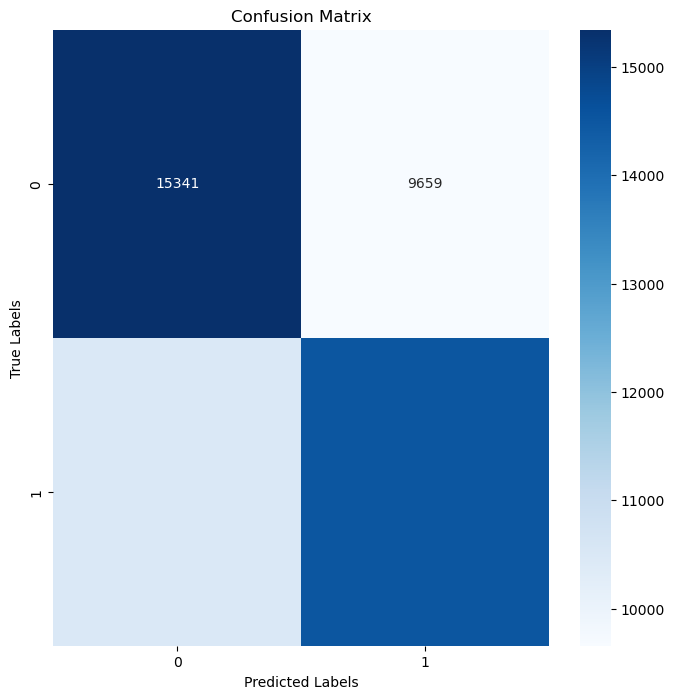

In [44]:
plt.figure(figsize=(8,8))
sns.heatmap(MatrixNMF, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

Predicted more correct data points than incorrect but accuracy is still very poor

In [53]:
dfNMF2=df
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [54]:
nmfModel2 =NMF(n_components=n, init='random', max_iter=200)
WNMF2 = nmfModel2.fit_transform(xtf)
ypNMF2=predict(WNMF2)
HNMF2 = nmfModel2.components_

In [55]:
labels2, accuracy2, bestmatch2 = permuteLabels(dfNMF2,ypNMF2,2)

In [56]:
#Results from second
print('Best Labels', labels2)
print('Best Accuracy', accuracy2)
print('Best Match for Labels', bestmatch2)

Best Labels (1, 0)
Best Accuracy 0.5639
Best Match for Labels {'positive': 1, 'negative': 0}


In [58]:
dfConfusionNMF2=dfNMF2
dfConfusionNMF2['sentiment'] = dfNMF2['sentiment'].replace({'positive': 1, 'negative': 0})
MatrixNMF2=confusion_matrix(dfConfusionNMF2['sentiment'],ypNMF2)

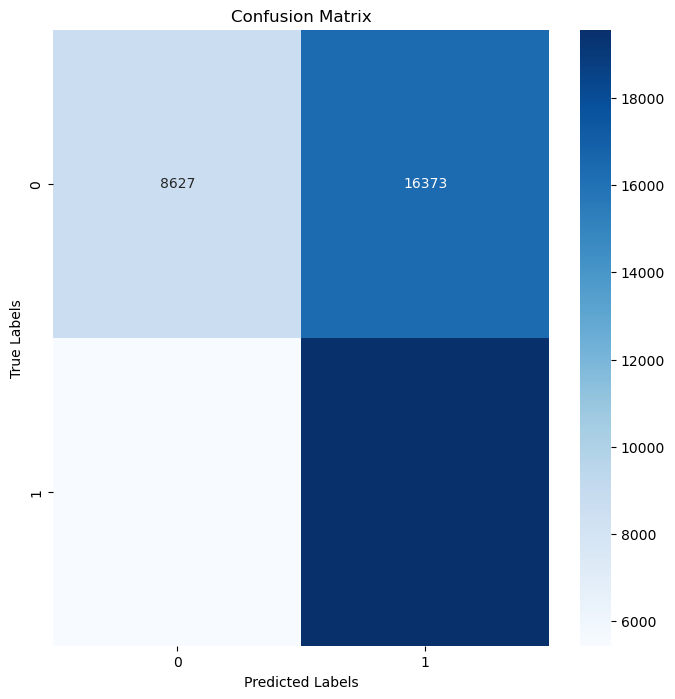

In [59]:
plt.figure(figsize=(8,8))
sns.heatmap(MatrixNMF2, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [ ]:
#This model did worse lets try clustering

## Agglomerative Clustering

In [24]:
dfReduced = df.head(2000)
n=2
vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,stop_words='english')
xtfAg = vectorizer.fit_transform(dfReduced['review'])

def makeAgglomerativeModel(data,linkageMethod, distanceMetric, n):
    model = AgglomerativeClustering(n_clusters=n, linkage=linkageMethod, affinity=distanceMetric)
    model.fit_predict(data.toarray())
    return model.labels_

linkageMethods = ['ward','complete', 'average','single']
distanceMetrics = ['euclidean','l1', 'l2', 'manhattan', 'cosine']


modelLabels=makeAgglomerativeModel(xtfAg,linkageMethods[0],distanceMetrics[0],2)
labelOrder, Acc, bestMatch = permuteLabels(dfReduced, modelLabels, 2)


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/tmp/ipykernel_67869/3662032590.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ytdf['test'] = ytdf['sentiment'].map(current)
/tmp/ipykernel_67869/3662032590.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ytdf['best']=ytdf['test']
/tmp/ipykernel_67869/3662032590.py:18: SettingWithCopyW

In [25]:
#Results from Agglomerative
print('Best Labels', labelOrder)
print('Best Accuracy', Acc)
print('Best Match for Labels', bestMatch)

Best Labels (0, 1)
Best Accuracy 0.5345
Best Match for Labels {'positive': 0, 'negative': 1}


In [26]:
dfConfusionAg=dfReduced
dfConfusionAg['sentiment'] = dfReduced['sentiment'].replace({'positive': 0, 'negative': 1})
MatrixAg=confusion_matrix(dfConfusionAg['sentiment'],modelLabels)

/tmp/ipykernel_67869/2236378982.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfConfusionAg['sentiment'] = dfReduced['sentiment'].replace({'positive': 0, 'negative': 1})


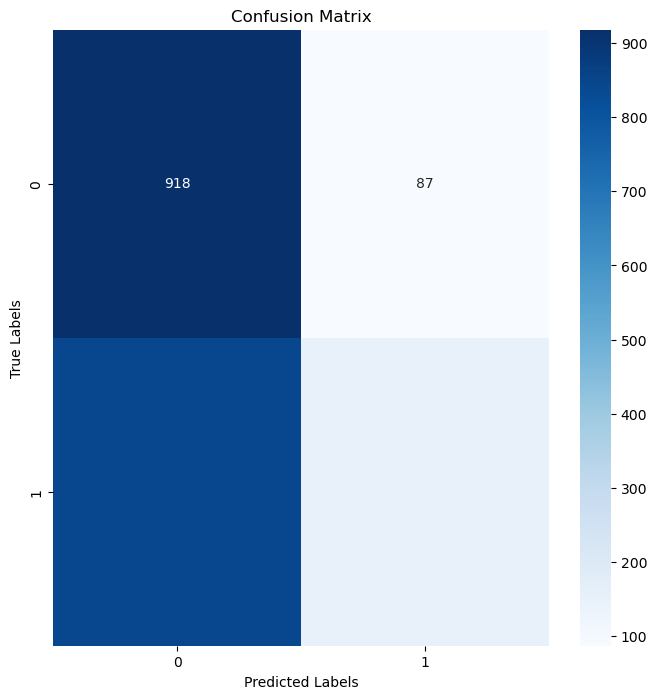

In [28]:
plt.figure(figsize=(8,8))
sns.heatmap(MatrixAg, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

Aglomerative Clustering did worse but I had to use a smaller dataset because I didn't have a fast enough machine to use all the data

## Spectral Clustering

One last clustering model

In [55]:
dfReduced = df.head(3000)
n=2
vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,stop_words='english')
xtfSpec = vectorizer.fit_transform(dfReduced['review'])

specModel = SpectralClustering(n_clusters=2, affinity='nearest_neighbors', n_neighbors=2)
clusterLabels = specModel.fit_predict(xtfSpec)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


In [56]:
clusterLabels

array([0, 0, 1, ..., 1, 0, 1], dtype=int32)

In [57]:
xtfSpec[:, 0]

<3000x1 sparse matrix of type '<class 'numpy.float64'>'
	with 7 stored elements in Compressed Sparse Row format>

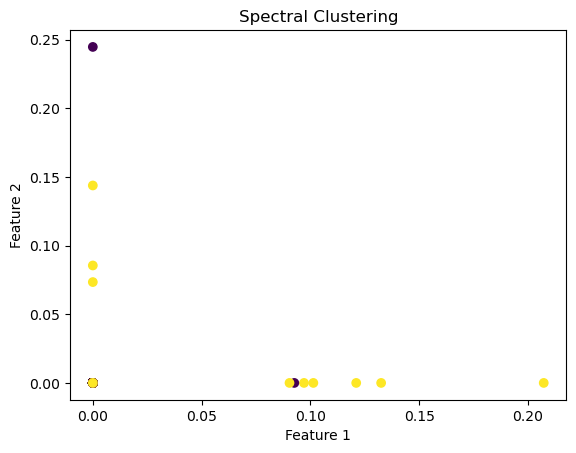

In [58]:
plt.scatter(xtfSpec.toarray()[:, 0], xtfSpec.toarray()[:, 1], c=clusterLabels, cmap='viridis')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Spectral Clustering')
plt.show()

In [59]:
labelOrderSpec, AccSpec, bestMatchSpec = permuteLabels(dfReduced, clusterLabels, 2)


/tmp/ipykernel_68260/3662032590.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ytdf['test'] = ytdf['sentiment'].map(current)
/tmp/ipykernel_68260/3662032590.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ytdf['best']=ytdf['test']
/tmp/ipykernel_68260/3662032590.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable

In [61]:
#Results from Spectral Clustering
print('Best Labels', labelOrderSpec)
print('Best Accuracy', AccSpec)
print('Best Match for Labels', bestMatchSpec)

Best Labels (0, 1)
Best Accuracy 0.506
Best Match for Labels {'positive': 0, 'negative': 1}


In [62]:
dfConfusionSpec=dfReduced
dfConfusionSpec['sentiment'] = dfReduced['sentiment'].replace({'positive': 0, 'negative': 1})
MatrixSpec=confusion_matrix(dfConfusionSpec['sentiment'],clusterLabels)

/tmp/ipykernel_68260/696743438.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfConfusionSpec['sentiment'] = dfReduced['sentiment'].replace({'positive': 0, 'negative': 1})


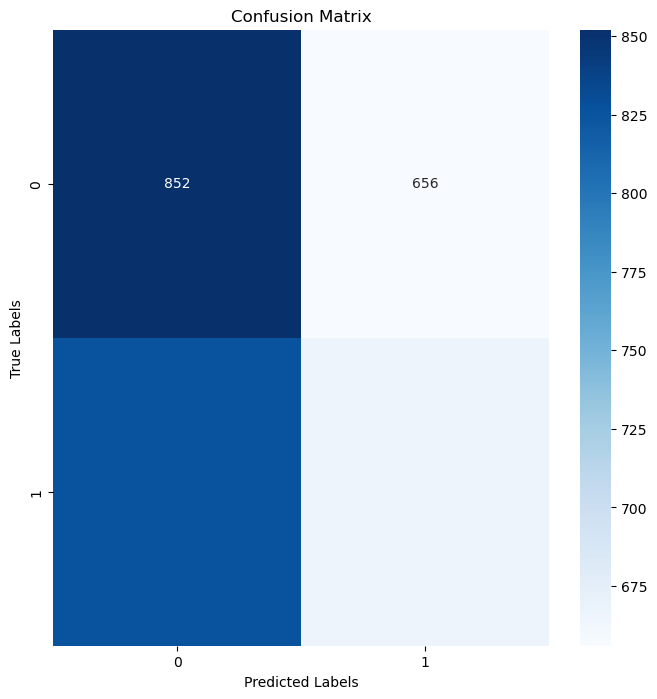

In [65]:
plt.figure(figsize=(8,8))
sns.heatmap(MatrixSpec, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()